Ментор проекта - Никита Селезнев (@Nikita в слаке)

Один из главных маркетинговых инструментов Яндекс.GO - брендирование машин. Его можно оптимизировать с точки зрения разных метрик: расходов, заметности, восприятия качества сервиса у пользователей и так далее. Например, можно влиять на эти метрики, разрешая или запрещая той или иной модели авто быть брендированной. Вокруг ответа на вопрос, какие модели стоит брендировать, и построен наш аналитический кейс. Мы, решим на какие метрики будем смотреть, проанализируем, как они меняются в зависимости от модельного ряда брендированных машин, сделаем допущения там, где посчитать честно не получается, и в результате получим data-driven подход к брендированию машин.

Условие и все файлы вот тут: https://yadi.sk/d/gg5BNLZ4yPzvEg?w=1

# Чтение данных

In [1]:
%cd /content/drive/My\ Drive/shad/pds/branding
!ls

/content/drive/My Drive/shad/pds/branding
data  eda_qa.ipynb  __pycache__  requirements.txt  utils.py


In [2]:
import pandas as pd

from utils import calc_stats_models
from utils import clf_by_defect_ratio
from utils import compare_clf_to_baseline
from utils import gridsearch_defect_ratio_threshold
from utils import plot_defect_rate_hist
from utils import plot_shares
from utils import plot_defect_ratios
from utils import plot_stats

In [3]:
!ls data

case_presentation.pptx	column_breakdown.txt  models.xlsx  partners.xlsx


In [4]:
with open('./data/column_breakdown.txt', 'r') as f:
    print(f.read())

Расшифровка колонок

models.xlsx

model - модель авто, например, BMW m3
year - год выпуска авто, например, 2020
can_be_branded - можно ли брендировать данную модель данного года в действующем классификаторе
car_cnt - количество машин данной модели и года в сервисе
car_sticker_cnt - количество оклеенных машин данной модели и года в сервисе
trips_success_cnt - количество успешных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
trips_cancel_cnt - количество отмененных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
trips_defect_cnt - количество дефектных поездок (с оценкой меньше 4 из 5), которые совершили пользователи на данной модели данного года авто за период анализа
trips_rated_cnt - количество оцененных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
bad_car_model_tag_cnt - количество тегов "не доволен моделью машины", которые пользователи поставили 

In [5]:
df_models = pd.read_excel('./data/models.xlsx', index_col=0)
df_partners = pd.read_excel('./data/partners.xlsx', index_col=0)

In [6]:
df_models.head()

,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt
0,model_207,year_20,False,1,0,12,3,0,5,0,0
1,model_482,year_19,False,1,0,12,4,0,4,0,0
2,model_499,year_7,False,1,0,46,1,0,14,0,0
3,model_499,year_8,False,3,0,1592,198,10,510,5,1
4,model_499,year_9,False,2,0,49,8,0,14,0,0


In [7]:
df_partners.head()

,partner,model,year,car_cnt,car_sticker_cnt
0,partner_6613,model_147,year_30,1,0
1,partner_7944,model_615,year_26,1,1
2,partner_7944,model_576,year_29,1,1
3,partner_7944,model_576,year_30,1,0
4,partner_7944,model_362,year_23,1,0


### Странности данных

- некоторые пары модель-год имеют ненулевое число обклеенных машин при `can_be_branded == False` в таблице `models`. Видимо, это локальные исключения из правила классификатора / легаси, оставшееся от старой версии, будем игнорировать.

In [8]:
df_models['car_sticker_cnt'][~df_models['can_be_branded']].sum()

293

In [9]:
df_models[(df_models['car_sticker_cnt'] != 0) & (~df_models['can_be_branded'])].head()

,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt
85,model_544,year_28,False,7,2,2403,298,22,814,5,4
86,model_544,year_29,False,8,1,2001,289,23,655,1,2
93,model_25,year_24,False,9,1,2583,417,26,801,8,2
95,model_423,year_28,False,8,1,1976,196,15,603,4,1
96,model_423,year_29,False,12,1,1541,251,14,480,3,2


- сумма числа машин `car_cnt` в таблице `models` не совпадает с суммой числа машин `car_cnt` в таблице `partners`, хотя ни там, ни там дубликатов по ключам нет. Аналогичная ситуация с `car_sticker_cnt`. Будем использовать значения из таблицы `models`.

In [10]:
df_models['car_cnt'].sum(), df_partners['car_cnt'].sum()

(33893, 41016)

# Что оптимизируем

Посчитаем долю обклееных машин.

In [11]:
df_models['car_sticker_cnt'].sum() / df_models['car_cnt'].sum()

0.14902782285427668

И долю машин, которые текущий классификатор позволяет обклеить.

In [12]:
df_models['car_cnt'][df_models['can_be_branded']].sum() / df_models['car_cnt'].sum()

0.7902221697695689

И долю обклеенных машин среди машин, которые текущий классификатор позволяет обклеить

In [13]:
df_models['car_sticker_cnt'][df_models['can_be_branded']].sum() / df_models['car_cnt'][df_models['can_be_branded']].sum()

0.17765000186685584

И поинтересуемся текущими статистиками второй основной метрики -- defect rate -- среди этих трех групп

In [14]:
df_models = calc_stats_models(df_models)

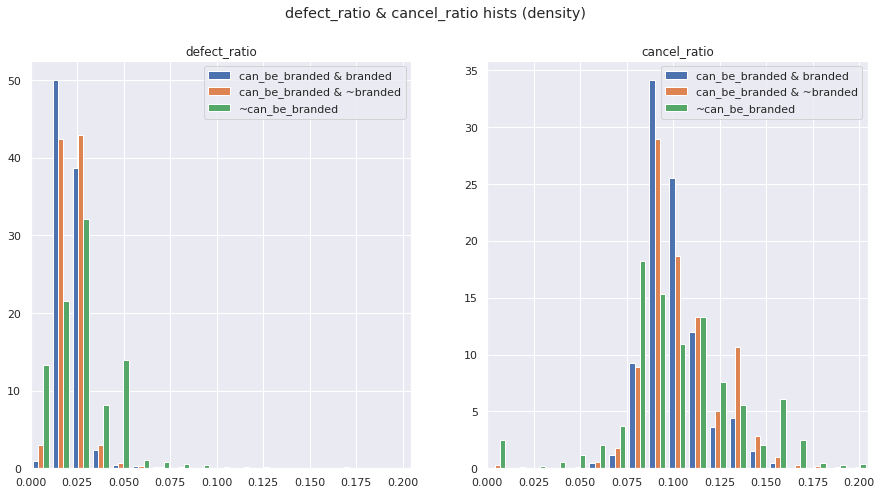

In [15]:
plot_defect_rate_hist(df_models)

In [18]:
df_models['car_cnt'][df_models['can_be_branded']].sum() / df_models['car_cnt'].sum()

0.7902221697695689

In [22]:
import numpy as np

threshold_values = np.arange(0, 0.1, 0.001)
p_sticking = df_models['car_sticker_cnt'][df_models['can_be_branded']].sum() / df_models['car_cnt'][df_models['can_be_branded']].sum()

stats = gridsearch_defect_ratio_threshold(df_models, p_sticking, threshold_values)

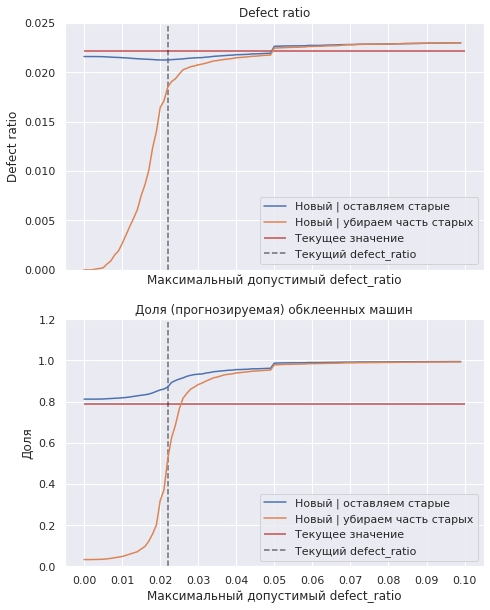

In [23]:
current_share = df_models['car_cnt'][df_models['can_be_branded']].sum() / df_models['car_cnt'].sum()
current_defect_ratio = (
    df_models['defect_ratio'][df_models['can_be_branded']] * 
    df_models['car_sticker_cnt'][df_models['can_be_branded']]
).sum() / df_models['car_sticker_cnt'][df_models['can_be_branded']].sum()

plot_stats(current_share, current_defect_ratio, stats)

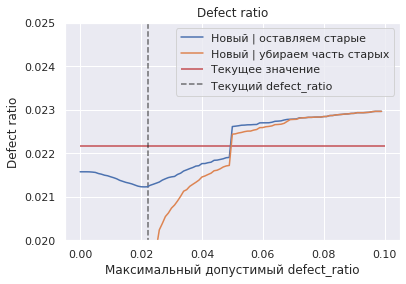

In [24]:
plot_defect_ratios(stats, current_defect_ratio, zoom=True)

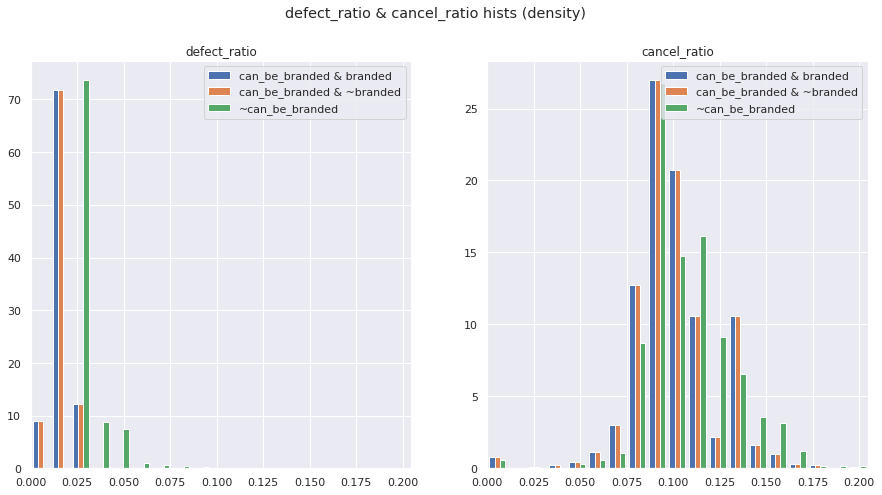

In [25]:
df_models = clf_by_defect_ratio(df_models, p_sticking, defect_ratio_threshold=current_defect_ratio)
plot_defect_rate_hist(df_models, clf_postfix='_new')

Таким образом, будем классифицировать машины по пороговому значению deffect rate в ~0.022 для старых партнеров. Для новых партнеров / машин будем использовать пороговое значение выше ~0.025 для того, чтобы не просадить SoV.

# Внедрение

Стратегия внедрения прделагается следующая:
- применим новый классификатор на существующих машинах и партнерах, не снимая при этом оклейку с уже брендированных машин. 
- ожидаем роста SoV и снижения DR
- для новых партнеров просто будем использовать новый классификатор с другим значением порога.